## 1. Import Libraries

In [1]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re

import gensim
from gensim import corpora

import string
from pathlib import Path
from pprint import pprint

from nltk.probability import FreqDist
import matplotlib.pyplot as plt

import seaborn as sns
# Set the visualisation style
sns.set(style="darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to C:\Users\Siew Leong
[nltk_data]     Kit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Siew Leong
[nltk_data]     Kit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Siew Leong
[nltk_data]     Kit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load Dataset

In [2]:
df=pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Data Understanding

In [3]:
# Check the number of rows of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
# Check for missing values
null_count=df.isnull().sum()
null_count

review       0
sentiment    0
dtype: int64

In [5]:
# Check for duplicates in 'review'
num_unique = df['review'].nunique()
print("Number of unique rows:", num_unique)
num_duplicates = df.duplicated(subset='review', keep=False).sum()
print("Number of duplicate rows:", num_duplicates)

Number of unique rows: 49582
Number of duplicate rows: 824


## 4. Data Cleaning

In [6]:
# Remove duplicates
df.drop_duplicates(subset='review', keep='first', inplace=True)
print(df.shape)

(49582, 2)


In [7]:
# Distribution of sentiments
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


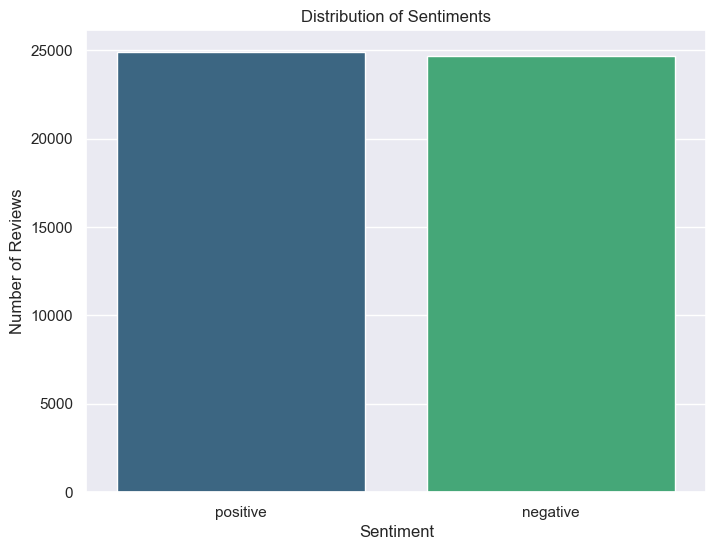

In [8]:
# Plot sentiment counts
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiments')
plt.show()

## 5. Data Pre-processing

In [9]:
# Download stopwords
stopwords_english = set(stopwords.words('english'))
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [10]:
def clean(doc):
    # Convert to lowercase and tokenize
    words = word_tokenize(doc.lower())
    # Remove stopwords, non-alphabetic words, words less than 4 characters
    words = [word for word in words if word not in stopwords_english and word.isalpha() and len(word) > 4]
    # Remove punctuation
    words = [''.join([ch for ch in word if ch not in exclude]) for word in words]
    # Lemmatization
    words = [lemma.lemmatize(word) for word in words]
    # Join the words back into a single string 
    cleaned_doc = ' '.join(words)
    return cleaned_doc
doc_clean = [clean(doc).split() for doc in df['review']]

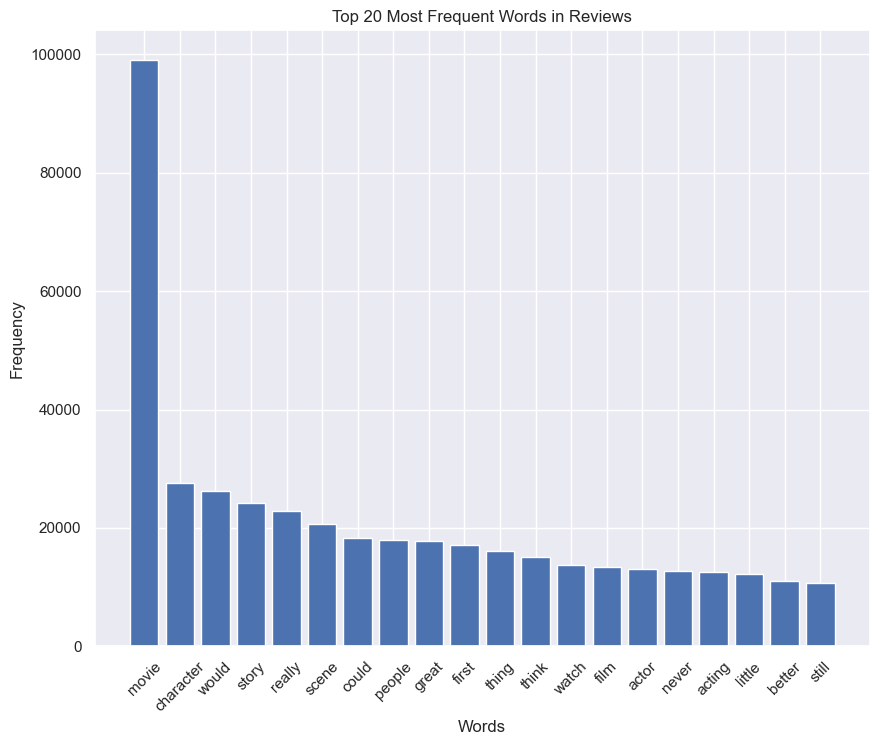

In [11]:
# Step 1: Flatten the list of words
all_words = [word for doc in doc_clean for word in doc]

# Step 2: Count the frequency of each word
word_freq = Counter(all_words)

# Convert to Dataframe for easier plotting
word_freq_df = pd.DataFrame(word_freq.items(), columns = ['Word', 'Frequency'])

# Sort the DataFrame by frequency
word_freq_df = word_freq_df.sort_values(by = 'Frequency', ascending = False)

# Step 3: Plot the word frequencies
plt.figure(figsize=(10,8))
plt.bar(word_freq_df['Word'][:20], word_freq_df['Frequency'][:20]) # Plot top 20 words
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in Reviews')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Update stopwords to include 'movie'
stopwords_english.update(['movie'])

In [13]:
# Re-apply the clean function to the reviews
df['cleaned_review'] = df['review'].apply(clean)

In [14]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,reviewer mentioned watching episode hooked rig...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful spend summer weekend sitting...
3,Basically there's a family where a little boy ...,negative,basically family little think zombie closet pa...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei money visually stunning watch ma...


In [15]:
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']

In [16]:
df_positive = df_positive.drop('review', axis=1)
df_positive.head()

,sentiment,cleaned_review
0,positive,reviewer mentioned watching episode hooked rig...
1,positive,wonderful little production filming technique ...
2,positive,thought wonderful spend summer weekend sitting...
4,positive,petter mattei money visually stunning watch ma...
5,positive,probably favorite story selflessness sacrifice...


In [17]:
df_negative = df_negative.drop('review', axis=1)
df_negative.head()

,sentiment,cleaned_review
3,negative,basically family little think zombie closet pa...
7,negative,amazing fresh innovative first aired first yea...
8,negative,encouraged positive comment looking forward wa...
10,negative,alien quirky film humour based around oddness ...
11,negative,recall scariest scene eating dangling helpless...


## 6. Creating bag of words for Positive sentiment

In [18]:
from gensim.utils import simple_preprocess

# Tokenize the cleaned_review column
df_positive['tokens'] = df_positive['cleaned_review'].apply(lambda x: simple_preprocess(x))

In [19]:
from gensim.corpora import Dictionary

# Create a dictionary from the tokenized text
dictionary = Dictionary(df_positive['tokens'])
dictionary.filter_extremes(no_below=3, no_above=0.5)

# Create a corpus: a list of Bag-of-Words (BoW) representations of the documents
corpus = [dictionary.doc2bow(text) for text in df_positive['tokens']]

## 7. Creating LDA model

In [20]:
from gensim.models import LdaModel

# Set the number of topics
topic_num =9
word_num = 5
# Train the LDA model
lda_model = LdaModel(corpus=corpus, num_topics=topic_num, id2word=dictionary, passes=20)

In [21]:
# Identify the topic for positive review
pprint(lda_model.print_topics(num_topics=topic_num, num_words=word_num))

[(0,
  '0.013*"batman" + 0.012*"doctor" + 0.009*"harry" + 0.008*"johnny" + '
  '0.007*"episode"'),
 (1,
  '0.017*"great" + 0.017*"really" + 0.014*"would" + 0.013*"character" + '
  '0.012*"think"'),
 (2,
  '0.007*"police" + 0.007*"murder" + 0.006*"scene" + 0.005*"match" + '
  '0.005*"crime"'),
 (3,
  '0.018*"horror" + 0.010*"scene" + 0.008*"film" + 0.006*"house" + '
  '0.006*"killer"'),
 (4,
  '0.007*"version" + 0.007*"film" + 0.006*"year" + 0.006*"scene" + '
  '0.006*"first"'),
 (5,
  '0.026*"music" + 0.020*"musical" + 0.012*"dance" + 0.011*"song" + '
  '0.009*"number"'),
 (6,
  '0.013*"performance" + 0.010*"woman" + 0.010*"family" + 0.010*"story" + '
  '0.009*"young"'),
 (7,
  '0.021*"comedy" + 0.011*"funny" + 0.006*"school" + 0.006*"hilarious" + '
  '0.005*"david"'),
 (8,
  '0.010*"character" + 0.010*"story" + 0.008*"people" + 0.006*"world" + '
  '0.005*"would"')]


In [22]:
#compute perplexity 
print('Perplexity: ', lda_model.log_perplexity(corpus))

Perplexity:  -8.609972342245404


## 8. Computing Coherence for positive sentiment

In [23]:
from gensim.models import CoherenceModel

coherence_values = []
model_list = []
num_topics_list = range(2, 11, 1)

for num_topics in num_topics_list:
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=20)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=df_positive['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

# Print coherence scores
for num_topics, coherence in zip(num_topics_list, coherence_values):
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence}")

Num Topics: 2, Coherence Score: 0.32498778681972074
Num Topics: 3, Coherence Score: 0.303797165801768
Num Topics: 4, Coherence Score: 0.3210206904487541
Num Topics: 5, Coherence Score: 0.3246860171829514
Num Topics: 6, Coherence Score: 0.3562413336843057
Num Topics: 7, Coherence Score: 0.375692010121064
Num Topics: 8, Coherence Score: 0.37137253219481975
Num Topics: 9, Coherence Score: 0.39377498614861417
Num Topics: 10, Coherence Score: 0.3934515341334302


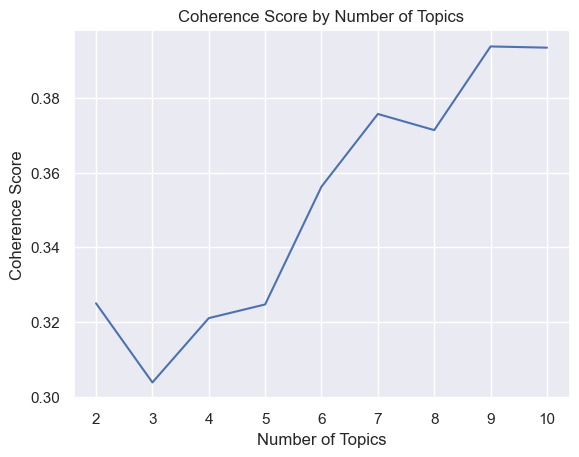

In [24]:
import matplotlib.pyplot as plt

plt.plot(num_topics_list, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score by Number of Topics')
plt.show()

## 9. Visualising topics and key words in positive sentiments

In [25]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline


Defaulting to user installation because normal site-packages is not writeable


In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.177926 -0.014137       1        1  26.747873
8     -0.180084 -0.059746       2        1  25.414789
6     -0.088903  0.037427       3        1  12.498440
4     -0.042546 -0.021450       4        1   9.528347
3     -0.110334 -0.096638       5        1   8.172089
2     -0.003696 -0.044289       6        1   8.080581
7      0.130594  0.099685       7        1   4.231107
5      0.119969  0.299181       8        1   3.429101
0      0.352926 -0.200033       9        1   1.897673, topic_info=           Term         Freq        Total Category  logprob  loglift
458       music  3900.000000  3900.000000  Default  30.0000  30.0000
103      comedy  3939.000000  3939.000000  Default  29.0000  29.0000
2265     horror  2939.000000  2939.000000  Default  28.0000  28.0000
2198      funny  3900.000000  3900.000000  Default  27.0000  27.0000
26      episode  3091.000000  3091.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
5531    monster   147.831286   672.243572   Topic9  -5.5229   2.4500
3902      danny   131.983121   371.068710   Topic9  -5.6363   2.9308
1558  scientist   129.251440   321.614617   Topic9  -5.6572   3.0529
859     richard   134.461843   897.064120   Topic9  -5.6177   2.0667
1686    villain   132.822222   805.448459   Topic9  -5.6300   2.1622

[675 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
206        1  0.581746  acting
206        2  0.121024  acting
206        3  0.192022  acting
206        4  0.000218  acting
206        5  0.103111  acting
...      ...       ...     ...
205        5  0.049287   young
205        6  0.072227   young
205        8  0.014309   young
4102       5  0.997478  zombie
12589      9  0.994602   zorro

[1663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 7, 5, 4, 3, 8, 6, 1])

## 10. Creating bag of words for Negative sentiment

In [27]:
# Tokenize the cleaned_review column
df_negative['tokens'] = df_negative['cleaned_review'].apply(lambda x: simple_preprocess(x))

# Create a dictionary from the tokenized text
dictionary2 = Dictionary(df_negative['tokens'])
dictionary2.filter_extremes(no_below=3, no_above=0.5)


# Create a corpus: a list of Bag-of-Words (BoW) representations of the documents
corpus2 = [dictionary2.doc2bow(text) for text in df_negative['tokens']]


## 11. Creating LDA model for negaitive sentiment

In [34]:
# Set the number of topics
topic_num =9 
word_num = 5
# Train the LDA model
lda_model2 = LdaModel(corpus=corpus2, num_topics=topic_num, id2word=dictionary2, passes=20)

In [35]:
# Identify the topic for negative review
pprint(lda_model2.print_topics(num_topics=topic_num, num_words=word_num))

[(0,
  '0.019*"character" + 0.015*"funny" + 0.014*"comedy" + 0.010*"episode" + '
  '0.010*"series"'),
 (1,
  '0.015*"character" + 0.011*"would" + 0.011*"story" + 0.007*"could" + '
  '0.006*"people"'),
 (2,
  '0.012*"scene" + 0.008*"woman" + 0.007*"horror" + 0.005*"killer" + '
  '0.005*"around"'),
 (3,
  '0.020*"fight" + 0.019*"action" + 0.017*"martial" + 0.015*"charlie" + '
  '0.014*"ninja"'),
 (4,
  '0.016*"would" + 0.015*"really" + 0.013*"could" + 0.012*"movie" + '
  '0.012*"acting"'),
 (5,
  '0.013*"actor" + 0.013*"performance" + 0.008*"story" + 0.008*"version" + '
  '0.007*"great"'),
 (6,
  '0.013*"effect" + 0.013*"zombie" + 0.012*"monster" + 0.009*"alien" + '
  '0.008*"vampire"'),
 (7,
  '0.020*"american" + 0.011*"black" + 0.011*"people" + 0.010*"western" + '
  '0.009*"white"'),
 (8,
  '0.028*"family" + 0.023*"mother" + 0.023*"child" + 0.018*"father" + '
  '0.016*"parent"')]


In [39]:
#compute perplexity 
print('Perplexity: ', lda_model2.log_perplexity(corpus2))

Perplexity:  -8.502795203398032


## 12. Computing coherence for negative sentiment

In [31]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Define range of topics to test
num_topics_list = range(2, 11, 1)

# Initialize lists to store models and coherence scores
coherence_values = []
model_list = []

# Iterate over the number of topics
for num_topics in num_topics_list:
    # Train LDA model
    lda_model = LdaModel(corpus=corpus2, num_topics=num_topics, id2word=dictionary2, passes=20)
    
    # Append the model to the list (optional)
    model_list.append(lda_model)
    
    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=df_negative['tokens'], dictionary=dictionary2, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    coherence_values.append(coherence_lda)
    
    # Print coherence score for current model
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_lda}")

Num Topics: 2, Coherence Score: 0.30600580033457236
Num Topics: 3, Coherence Score: 0.3165760479677825
Num Topics: 4, Coherence Score: 0.3567242706939402
Num Topics: 5, Coherence Score: 0.33007732886034313
Num Topics: 6, Coherence Score: 0.3566866757211533
Num Topics: 7, Coherence Score: 0.3211511429366101
Num Topics: 8, Coherence Score: 0.35902655176682946
Num Topics: 9, Coherence Score: 0.3881786141097826
Num Topics: 10, Coherence Score: 0.37476228085587887


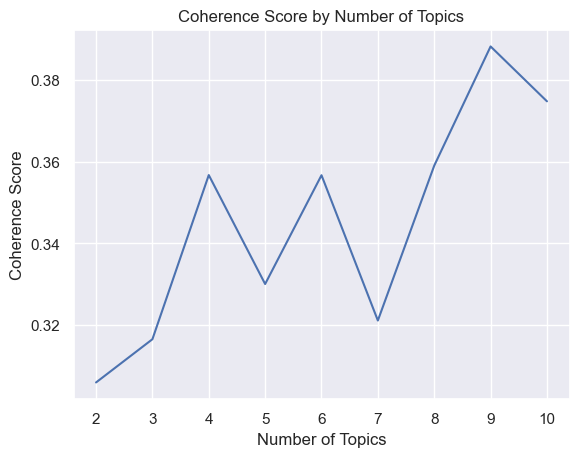

In [32]:
# Plot coherence scores
plt.plot(num_topics_list, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score by Number of Topics')
plt.show()

## 13. Visualise topics and key words in negative sentiments

In [40]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim_models.prepare(lda_model2, corpus2, dictionary2)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.206039 -0.029467       1        1  32.493485
2     -0.111086  0.013874       2        1  19.039631
1     -0.173845 -0.034403       3        1  18.765107
0     -0.125068  0.036038       4        1   8.298289
5     -0.082337  0.033006       5        1   8.283809
6      0.014403 -0.132961       6        1   5.932573
7      0.154365 -0.146539       7        1   3.446663
8      0.160846  0.359740       8        1   2.591860
3      0.368759 -0.099288       9        1   1.148581, topic_info=           Term          Freq         Total Category  logprob  loglift
120   character  14180.000000  14180.000000  Default  30.0000  30.0000
396       actor   6906.000000   6906.000000  Default  29.0000  29.0000
395      action   3055.000000   3055.000000  Default  28.0000  28.0000
54        funny   4314.000000   4314.000000  Default  27.0000  27.0000
226      people   9261.000000   9261.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
13     fighting    189.379429    618.391690   Topic9  -4.7088   3.2833
5463    chaplin     95.038205    114.949989   Topic9  -5.3983   4.2764
356       sword    107.994886    196.005845   Topic9  -5.2705   3.8706
3376    warrior    106.478983    205.577231   Topic9  -5.2846   3.8088
1418      jones    110.859186    405.862425   Topic9  -5.2443   3.1689

[627 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
11236      8  0.988420  abortion
1554       1  0.307642    accent
1554       4  0.014254    accent
1554       5  0.348027    accent
1554       7  0.329022    accent
...      ...       ...       ...
4231       2  0.032581   younger
4231       4  0.298240   younger
4231       5  0.162904   younger
4231       8  0.503750   younger
34         6  0.999370    zombie

[1396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 6, 7, 8, 9, 4])